# Penguins Dataset Multiple Linear Regression - Linear Regression

### [Penguins Dataset](https://seaborn.pydata.org/tutorial/introduction.html)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Citation

[1] Allison Horst, https://github.com/allisonhorst/palmerpenguins

## Import Modules

In [68]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Load Dataset

In [69]:
df = sns.load_dataset('penguins')

## Perform Essential Exploration & Data Cleaning

#### Display the initial number of rows and columns.

In [70]:
df.shape

(344, 7)

#### Display the initial variable names and their associated data types.

In [71]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

#### Display the number of missing values for each column, remove the missing values and create a clean copy of the dataset.

In [72]:
df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [73]:
df_clean = df.dropna().copy()

In [74]:
df_clean.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

#### Display the number of unique values for each column after removing missing data and before initial exploration.

In [75]:
df_clean.nunique()

species                3
island                 3
bill_length_mm       163
bill_depth_mm         79
flipper_length_mm     54
body_mass_g           93
sex                    2
dtype: int64

#### Display the number of unique values for the categorical variables after removing missing data and before initial exploration.

In [76]:
df_clean.select_dtypes(exclude='number').nunique()

species    3
island     3
sex        2
dtype: int64

#### Display the number of unique values for the continuous variables after removing missing data and before initial exploration.

In [77]:
df_clean.select_dtypes(include='number').nunique()

bill_length_mm       163
bill_depth_mm         79
flipper_length_mm     54
body_mass_g           93
dtype: int64

## Linear Regression

### Visualize Relationship Between the Output and Each Continuous Input

Body mass increases with each predictor (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`), and the 3 species form separate clusters with Gentoo (green) largest, Chinstrap (orange) intermediate, and Adelie (blue) smallest.

There are very clear relationships between all 3 continuous inputs and the target.

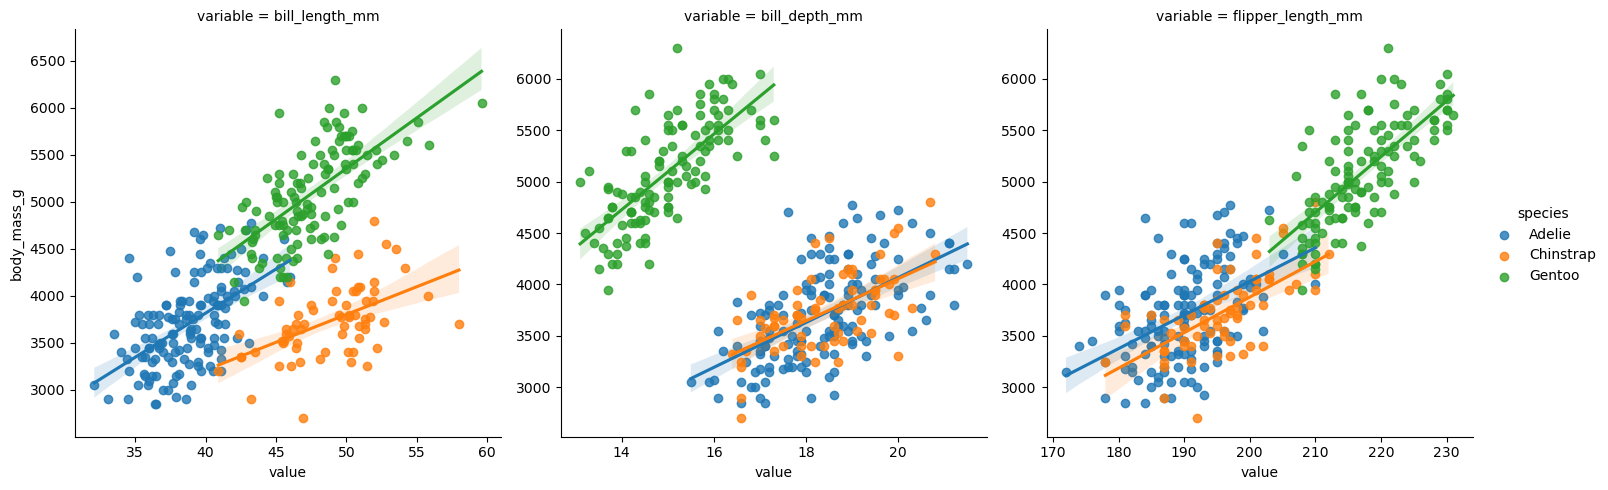

In [78]:
sns.lmplot(
    data=df_clean. \
         reset_index(). \
         rename(columns={'index':'rowid'}). \
         melt(id_vars=['rowid',
                       'body_mass_g',
                       'species'],
         value_vars=['bill_length_mm',''
                     'bill_depth_mm',
                     'flipper_length_mm']),
    x='value',
    y='body_mass_g',
    col='variable',
    hue='species',
    facet_kws={'sharey': False, 
               'sharex': False})
plt.show()

## Initially Fit Linear Regression Models - Training Data

### Functions

In [79]:
def fit_and_assess_ols(model, 
                       formula, 
                       df):
    """
    Fits an Ordinary Least Squares (OLS) regression model using statsmodels and returns model metrics.

    Parameters
    ----------
    model : str
        A descriptive name for the model.
    formula : str
        A statsmodels formula string specifying the regression model.
    df : pandas.DataFrame
        The input data to fit the model.

    Returns
    -------
    pandas.DataFrame
        A single-row DataFrame containing:
            - 'model_name': Name of the model
            - 'model_formula': Formula used for fitting
            - 'num_coefs': Number of estimated coefficients
            - 'R-squared': Model R-squared statistic
            - 'RMSE': Root Mean Squared Error of residuals
    """
    # Fit the model
    a_model = smf.ols(formula=formula, data=df).fit()

    # Extract model metrics
    results_dict = {'model_name': model,
                'model_formula': formula,
                'num_coefs': len(a_model.params),
                'R-squared': a_model.rsquared,
                'RMSE': np.sqrt((a_model.resid ** 2).mean())}

    # Return results as DataFrame
    return pd.DataFrame(results_dict, index=[0])

In [80]:
def my_coefplot(model, 
                figsize_use=(10, 8), 
                zero_nudge=125):
    """
    Create a coefficient plot of a fitted statsmodels regression model.

    This function visualizes the estimated coefficients of a regression model with their
    confidence intervals (approximated as ±2 standard errors).
    Statistically significant coefficients (p < 0.05) are shown in red.

    Parameters
    ----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        A fitted statsmodels regression model, e.g., the result of smf.ols(...).fit().
    figsize_use : tuple, optional
        Size of the matplotlib figure, default is (10, 4).
    zero_nudge : float, optional
        Amount to nudge significant coefficients away from zero for visual clarity. Default is 125.

    Returns
    -------
    None
        Displays a matplotlib plot showing the model coefficients and their error bars.
    """
    # Create the figure and axis
    _, ax = plt.subplots(figsize=figsize_use)

    # Nudge coefficients very close to zero for visual clarity
    coefs = model.params.copy()
    coefs[np.isclose(coefs, 0, atol=zero_nudge)] = zero_nudge

    # Determine colors for coefficients based on significance
    colors = ['red' if p < 0.05 else 'black' for p in model.pvalues]

    # Plot each coefficient with its color
    for _, (y, x, xerr, color) in enumerate(zip(coefs.index, coefs, 2 * model.bse, colors)):
        ax.errorbar([x], 
                    [y], 
                    xerr=[xerr], 
                    fmt='o', 
                    color=color, 
                    ecolor=color, 
                    elinewidth=2, 
                    ms=10)

    # Add a vertical line at x=0
    ax.axvline(x=0, 
               linestyle='--', 
               linewidth=3.5, 
               color='grey')

    # Add labels and title
    ax.set_xlabel('Coefficient Value')

    # Show the plot
    plt.show()

### Formulas

In [81]:
formula_list = [
    # Model 00: Intercept-Only (Baseline)
    'Q("body_mass_g") ~ '
    '1',

    # Model 01: Species (Categorical) Only
    'Q("body_mass_g") ~ '
    'C(Q("species"))',

    # Model 02: Continuous Predictors, Linear Additive
    'Q("body_mass_g") ~ '
    'Q("bill_length_mm")'
    ' + Q("bill_depth_mm")'
    ' + Q("flipper_length_mm")',

    # Model 03: Continuous Predictors + Species (Additive)
    'Q("body_mass_g") ~ '
    'Q("bill_length_mm")'
    ' + Q("bill_depth_mm")'
    ' + Q("flipper_length_mm")'
    ' + C(Q("species"))',

    # Model 04: Continuous Predictors with Pairwise Interactions and Quadratic Terms
    'Q("body_mass_g") ~ '
    'Q("bill_length_mm")'
    ' + Q("bill_depth_mm")'
    ' + Q("flipper_length_mm")'
    ' + Q("bill_length_mm"):Q("bill_depth_mm")'
    ' + Q("bill_length_mm"):Q("flipper_length_mm")'
    ' + Q("bill_depth_mm"):Q("flipper_length_mm")'
    ' + I(Q("bill_length_mm") ** 2)'
    ' + I(Q("bill_depth_mm") ** 2)'
    ' + I(Q("flipper_length_mm") ** 2)',

    # Model 05: Species Interacting with All Continuous Predictors (Allows Species-Specific Slopes)
    'Q("body_mass_g") ~ '
    'C(Q("species")) * ('
    'Q("bill_length_mm")'
    ' + Q("bill_depth_mm")'
    ' + Q("flipper_length_mm")'
    ')',

    # Model 06: Higher-Order Polynomials on Flipper Length (If Non-Linear Scaling Suspected)
    'Q("body_mass_g") ~ '
    'Q("bill_length_mm")'
    ' + Q("bill_depth_mm")'
    ' + Q("flipper_length_mm")'
    ' + I(Q("flipper_length_mm") ** 2)'
    ' + I(Q("flipper_length_mm") ** 3)',

    # Model 07: All Predictors, Interactions Among Continuous Terms, and Species (Full Candidate)
    'Q("body_mass_g") ~ '
    '(Q("bill_length_mm") + Q("bill_depth_mm") + Q("flipper_length_mm"))**2'
    ' + C(Q("species"))',

    # Model 08: Final Model (Species-Specific Slope for Flipper Length)
    'Q("body_mass_g") ~ '
    'Q("flipper_length_mm")'
    ' + Q("bill_length_mm")'
    ' + C(Q("species"))'
    ' + Q("flipper_length_mm"):C(Q("species"))'
]

### Model 00: Intercept-Only (Baseline)

In [82]:
model_00 = smf.ols(formula=formula_list[0], 
                   data=df_clean). \
                   fit()

In [83]:
model_00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 31 Aug 2025   Prob (F-statistic):                nan
Time:                        16:36:52   Log-Likelihood:                -2700.1
No. Observations:                 333   AIC:                             5402.
Df Residuals:                     332   BIC:                             5406.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4207.0571     44.126     95.343      0.000    4120.256    4293.858
==============================================================================
Omnibus:                       30.464   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.874
Skew:                           0.470   Prob(JB):                     4.84e-05
Kurtosis:                       2.260   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

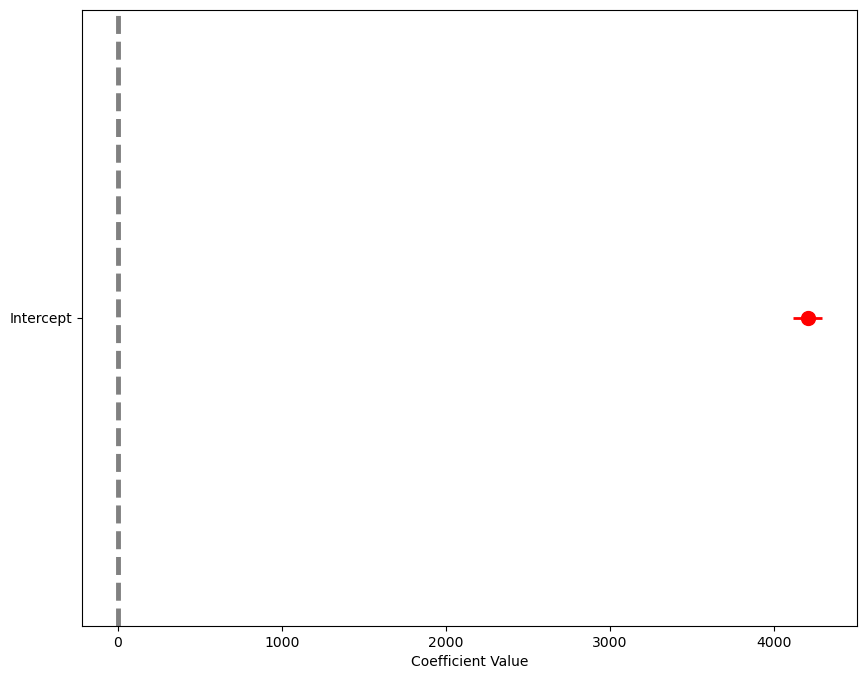

In [84]:
my_coefplot(model_00)

### Model 01: Species (Categorical) Only

In [85]:
model_01 = smf.ols(formula=formula_list[1], 
                   data=df_clean). \
                   fit()

In [86]:
model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     341.9
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           3.74e-81
Time:                        16:36:52   Log-Likelihood:                -2513.3
No. Observations:                 333   AIC:                             5033.
Df Residuals:                     330   BIC:                             5044.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     3706.1644     38.136     97.184      0.000    3631.145    3781.184
C(Q("species"))[T.Chinstrap]    26.9239     67.652      0.398      0.691    -106.161     160.008
C(Q("species"))[T.Gentoo]     1386.2726     56.909     24.359      0.000    1274.323    1498.223
==============================================================================
Omnibus:                        6.944   Durbin-Watson:                   2.983
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                4.976
Skew:                           0.169   Prob(JB):                       0.0831
Kurtosis:                       2.506   Cond. No.                         3.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

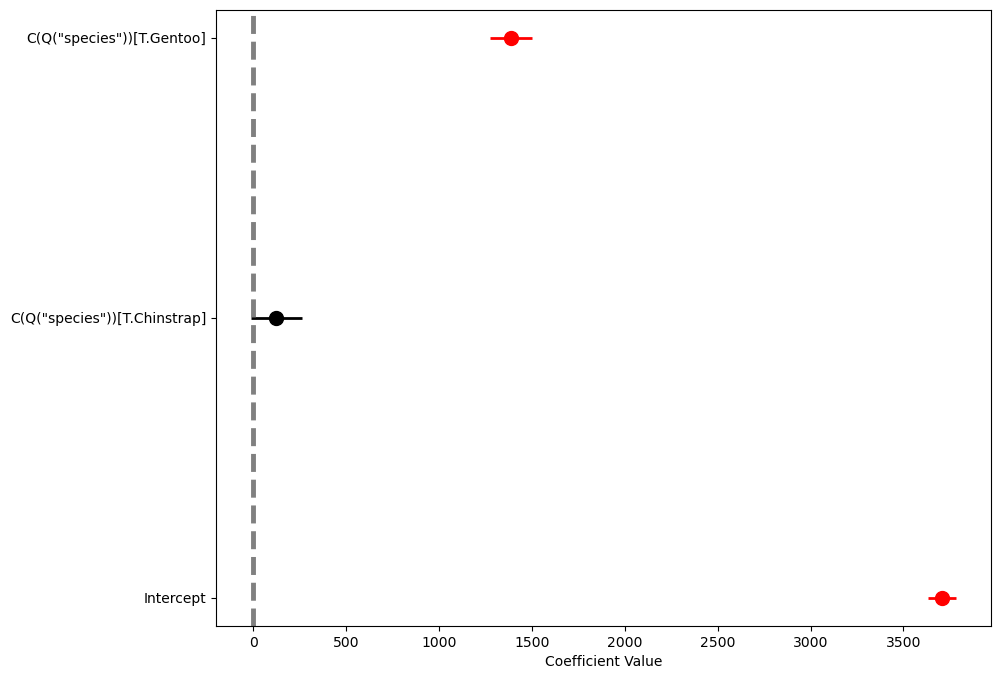

In [87]:
my_coefplot(model_01)

### Model 02: Continuous Predictors, Linear Additive

In [88]:
model_02 = smf.ols(formula=formula_list[2], 
                   data=df_clean). \
                   fit()

In [89]:
model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     354.9
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          9.26e-103
Time:                        16:36:52   Log-Likelihood:                -2459.8
No. Observations:                 333   AIC:                             4928.
Df Residuals:                     329   BIC:                             4943.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -6445.4760    566.130    -11.385      0.000   -7559.167   -5331.785
Q("bill_length_mm")        3.2929      5.366      0.614      0.540      -7.263      13.849
Q("bill_depth_mm")        17.8364     13.826      1.290      0.198      -9.362      45.035
Q("flipper_length_mm")    50.7621      2.497     20.327      0.000      45.850      55.675
==============================================================================
Omnibus:                        5.596   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.469
Skew:                           0.312   Prob(JB):                       0.0649
Kurtosis:                       3.068   Cond. No.                     5.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

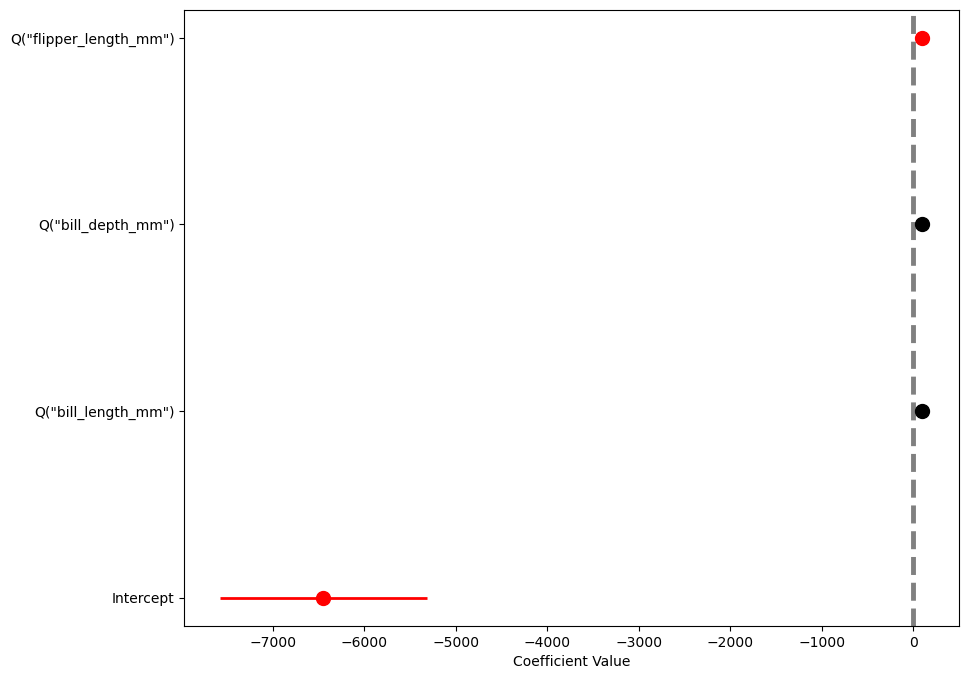

In [90]:
my_coefplot(model_02, zero_nudge=90)

### Model 03: Continuous Predictors + Species (Additive)

In [91]:
model_03 = smf.ols(formula=formula_list[3], 
                   data=df_clean). \
                   fit()

In [92]:
model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     369.1
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          4.22e-132
Time:                        16:36:52   Log-Likelihood:                -2384.8
No. Observations:                 333   AIC:                             4782.
Df Residuals:                     327   BIC:                             4805.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4282.0802    497.832     -8.601      0.000   -5261.438   -3302.723
C(Q("species"))[T.Chinstrap]  -496.7583     82.469     -6.024      0.000    -658.995    -334.521
C(Q("species"))[T.Gentoo]      965.1983    141.770      6.808      0.000     686.301    1244.096
Q("bill_length_mm")             39.7184      7.227      5.496      0.000      25.501      53.936
Q("bill_depth_mm")             141.7714     19.163      7.398      0.000     104.072     179.470
Q("flipper_length_mm")          20.2264      3.135      6.452      0.000      14.059      26.394
==============================================================================
Omnibus:                        7.321   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.159
Skew:                           0.348   Prob(JB):                       0.0279
Kurtosis:                       3.179   Cond. No.                     6.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

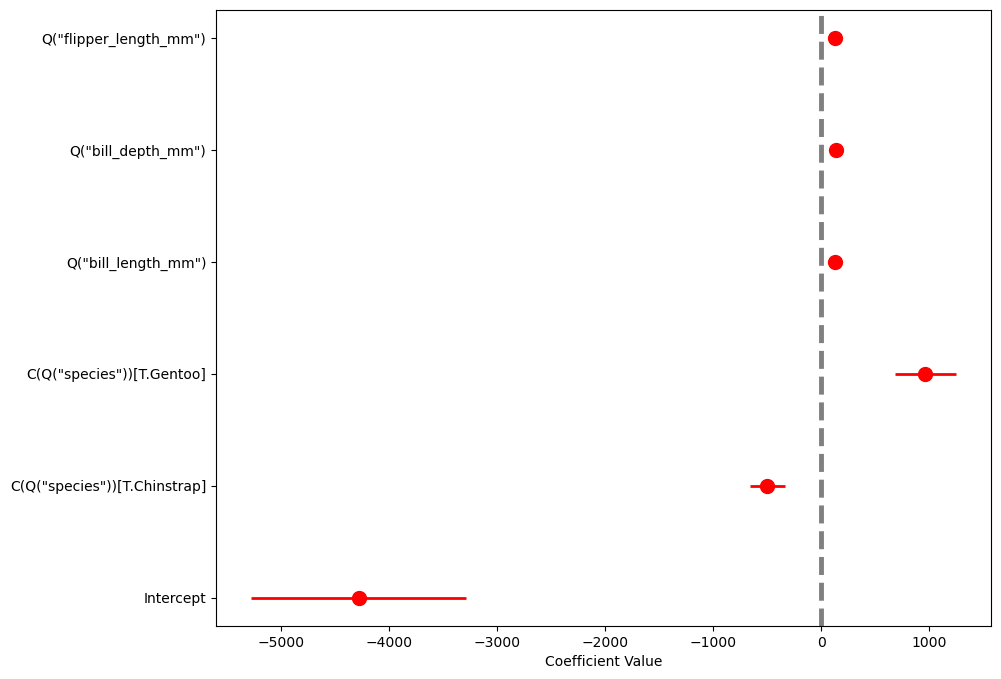

In [93]:
my_coefplot(model_03)

### Model 04: Continuous Predictors with Pairwise Interactions and Quadratic Terms

In [94]:
model_04 = smf.ols(formula=formula_list[4], 
                   data=df_clean). \
                   fit()

In [95]:
model_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     159.1
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          4.75e-113
Time:                        16:36:52   Log-Likelihood:                -2418.4
No. Observations:                 333   AIC:                             4857.
Df Residuals:                     323   BIC:                             4895.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                  -1.001e+04   1.14e+04     -0.878      0.381   -3.25e+04    1.24e+04
Q("bill_length_mm")                          203.8636    122.035      1.671      0.096     -36.221     443.948
Q("bill_depth_mm")                          1178.9782    539.781      2.184      0.030     117.048    2240.909
Q("flipper_length_mm")                       -54.0439     84.854     -0.637      0.525    -220.981     112.893
Q("bill_length_mm"):Q("bill_depth_mm")       -10.7817      3.224     -3.344      0.001     -17.125      -4.438
Q("bill_length_mm"):Q("flipper_length_mm")     0.9314      0.564      1.652      0.099      -0.178       2.040
Q("bill_depth_mm"):Q("flipper_length_mm")     -4.1625      2.086     -1.996      0.047      -8.266      -0.059
I(Q("bill_length_mm") ** 2)                   -2.0777      0.824     -2.522      0.012      -3.699      -0.457
I(Q("bill_depth_mm") ** 2)                     4.8728      6.879      0.708      0.479      -8.661      18.406
I(Q("flipper_length_mm") ** 2)                 0.3112      0.186      1.673      0.095      -0.055       0.677
==============================================================================
Omnibus:                        9.149   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.132
Skew:                           0.395   Prob(JB):                       0.0104
Kurtosis:                       3.181   Cond. No.                     2.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

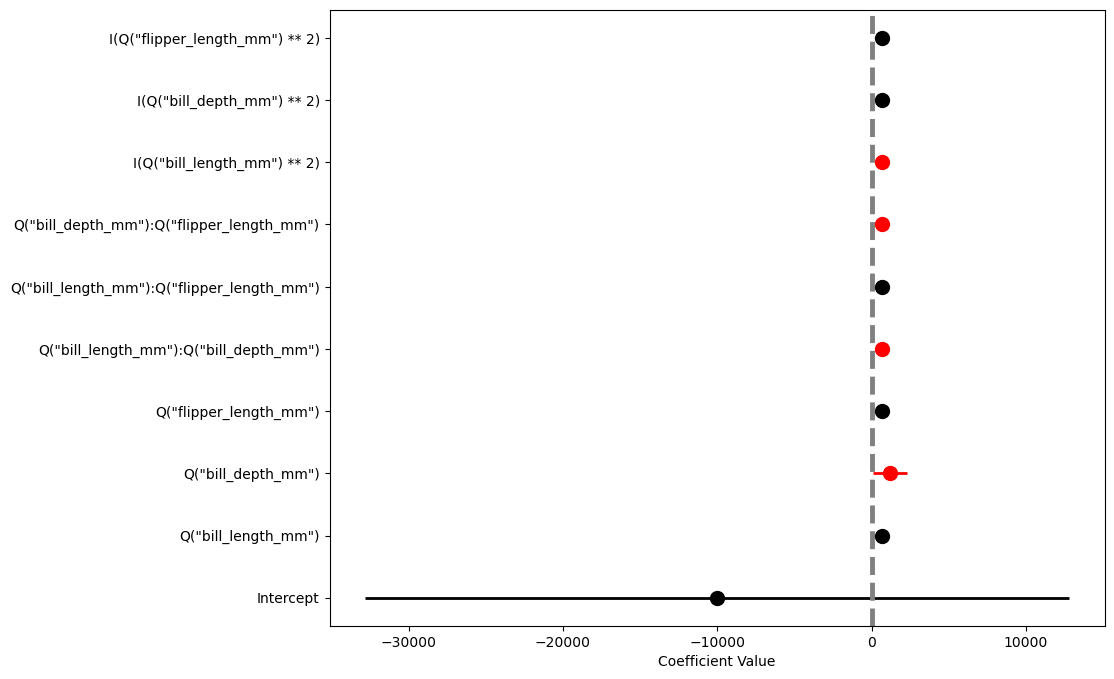

In [96]:
my_coefplot(model_04, zero_nudge=700)

### Model 05: Species Interacting with All Continuous Predictors (Allows Species-Specific Slopes)

In [97]:
model_05 = smf.ols(formula=formula_list[5], 
                   data=df_clean). \
                   fit()

In [98]:
model_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     173.4
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          7.27e-128
Time:                        16:36:52   Log-Likelihood:                -2377.5
No. Observations:                 333   AIC:                             4779.
Df Residuals:                     321   BIC:                             4825.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -4270.6550    774.961     -5.511      0.000   -5795.299   -2746.011
C(Q("species"))[T.Chinstrap]                         1113.1250   1301.811      0.855      0.393   -1448.034    3674.284
C(Q("species"))[T.Gentoo]                            -173.7598   1274.837     -0.136      0.892   -2681.851    2334.332
Q("bill_length_mm")                                    54.5124     10.828      5.034      0.000      33.209      75.816
C(Q("species"))[T.Chinstrap]:Q("bill_length_mm")      -38.4733     18.657     -2.062      0.040     -75.179      -1.768
C(Q("species"))[T.Gentoo]:Q("bill_length_mm")         -16.9957     17.021     -0.999      0.319     -50.482      16.490
Q("bill_depth_mm")                                    144.1567     23.465      6.144      0.000      97.993     190.320
C(Q("species"))[T.Chinstrap]:Q("bill_depth_mm")       -52.6440     53.766     -0.979      0.328    -158.422      53.134
C(Q("species"))[T.Gentoo]:Q("bill_depth_mm")           35.8488     49.827      0.719      0.472     -62.180     133.877
Q("flipper_length_mm")                                 16.9148      4.291      3.942      0.000       8.472      25.357
C(Q("species"))[T.Chinstrap]:Q("flipper_length_mm")     5.6649      7.881      0.719      0.473      -9.840      21.170
C(Q("species"))[T.Gentoo]:Q("flipper_length_mm")        6.3447      7.923      0.801      0.424      -9.242      21.931
==============================================================================
Omnibus:                        8.160   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.027
Skew:                           0.357   Prob(JB):                       0.0181
Kurtosis:                       3.264   Cond. No.                     2.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

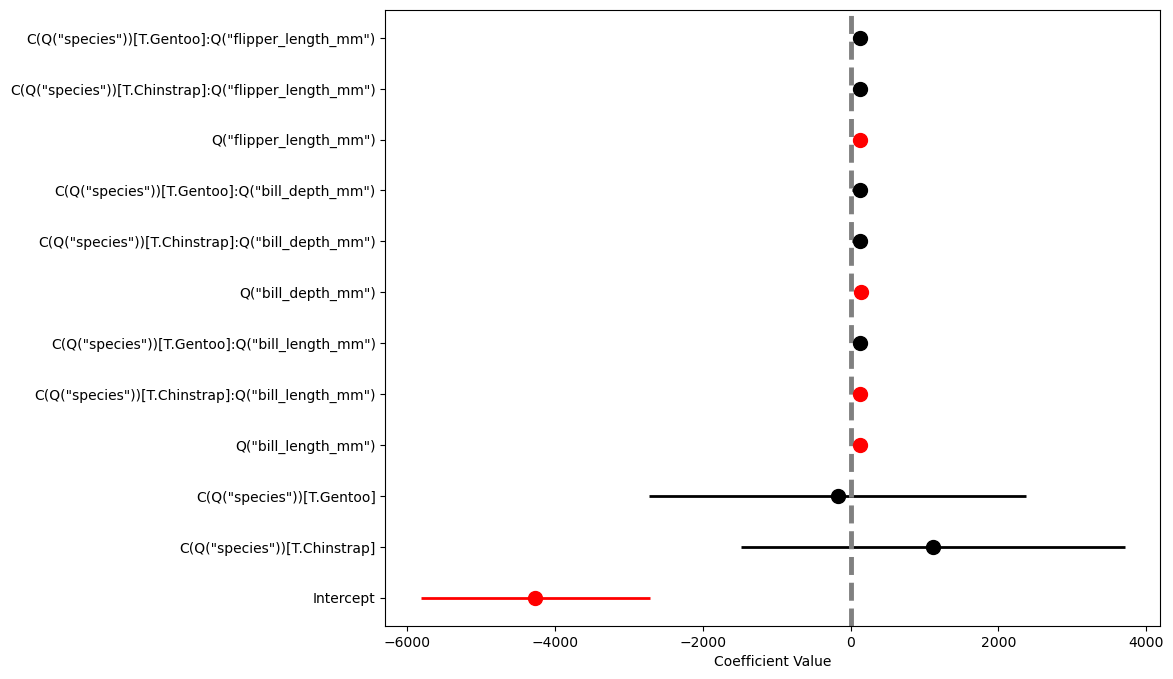

In [99]:
my_coefplot(model_05, zero_nudge=120)

### Model 06: Higher-Order Polynomials on Flipper Length (If Non-Linear Scaling Suspected)

In [100]:
model_06 = smf.ols(formula=formula_list[6], 
                   data=df_clean). \
                   fit()

In [101]:
model_06.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     250.8
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.43e-109
Time:                        16:36:52   Log-Likelihood:                -2437.8
No. Observations:                 333   AIC:                             4888.
Df Residuals:                     327   BIC:                             4910.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       2.831e+05   6.13e+04      4.616      0.000    1.62e+05    4.04e+05
Q("bill_length_mm")                1.4184      5.070      0.280      0.780      -8.555      11.392
Q("bill_depth_mm")                53.4670     14.687      3.640      0.000      24.573      82.361
Q("flipper_length_mm")         -4143.6361    911.346     -4.547      0.000   -5936.478   -2350.795
I(Q("flipper_length_mm") ** 2)    20.1267      4.493      4.479      0.000      11.287      28.966
I(Q("flipper_length_mm") ** 3)    -0.0320      0.007     -4.354      0.000      -0.047      -0.018
==============================================================================
Omnibus:                       10.214   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.260
Skew:                           0.408   Prob(JB):                      0.00592
Kurtosis:                       3.272   Cond. No.                     2.55e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

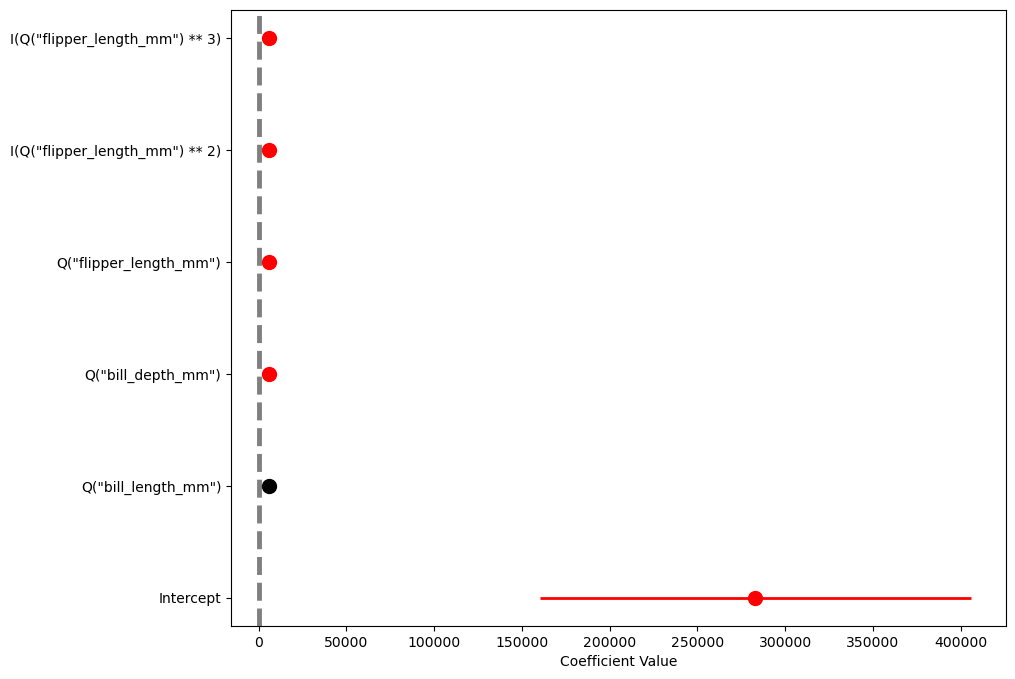

In [102]:
my_coefplot(model_06, zero_nudge=6200)

### Model 07: All Predictors, Interactions Among Continuous Terms, and Species (Full Candidate)

In [103]:
model_07 = smf.ols(formula=formula_list[7], 
                   data=df_clean). \
                   fit()

In [104]:
model_07.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     233.7
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.30e-129
Time:                        16:36:53   Log-Likelihood:                -2381.7
No. Observations:                 333   AIC:                             4781.
Df Residuals:                     324   BIC:                             4816.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                  -6490.4539   5383.685     -1.206      0.229   -1.71e+04    4100.938
C(Q("species"))[T.Chinstrap]                -441.1314     89.228     -4.944      0.000    -616.671    -265.592
C(Q("species"))[T.Gentoo]                    908.7480    162.852      5.580      0.000     588.366    1229.130
Q("bill_length_mm")                          139.4687     83.530      1.670      0.096     -24.860     303.798
Q("bill_depth_mm")                           297.0222    288.078      1.031      0.303    -269.718     863.762
Q("flipper_length_mm")                         7.1624     28.747      0.249      0.803     -49.391      63.716
Q("bill_length_mm"):Q("bill_depth_mm")        -6.4401      2.765     -2.329      0.020     -11.880      -1.000
Q("bill_length_mm"):Q("flipper_length_mm")     0.0691      0.294      0.235      0.815      -0.510       0.648
Q("bill_depth_mm"):Q("flipper_length_mm")      0.5889      1.598      0.369      0.713      -2.554       3.732
==============================================================================
Omnibus:                        6.344   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.131
Skew:                           0.321   Prob(JB):                       0.0466
Kurtosis:                       3.173   Cond. No.                     3.04e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

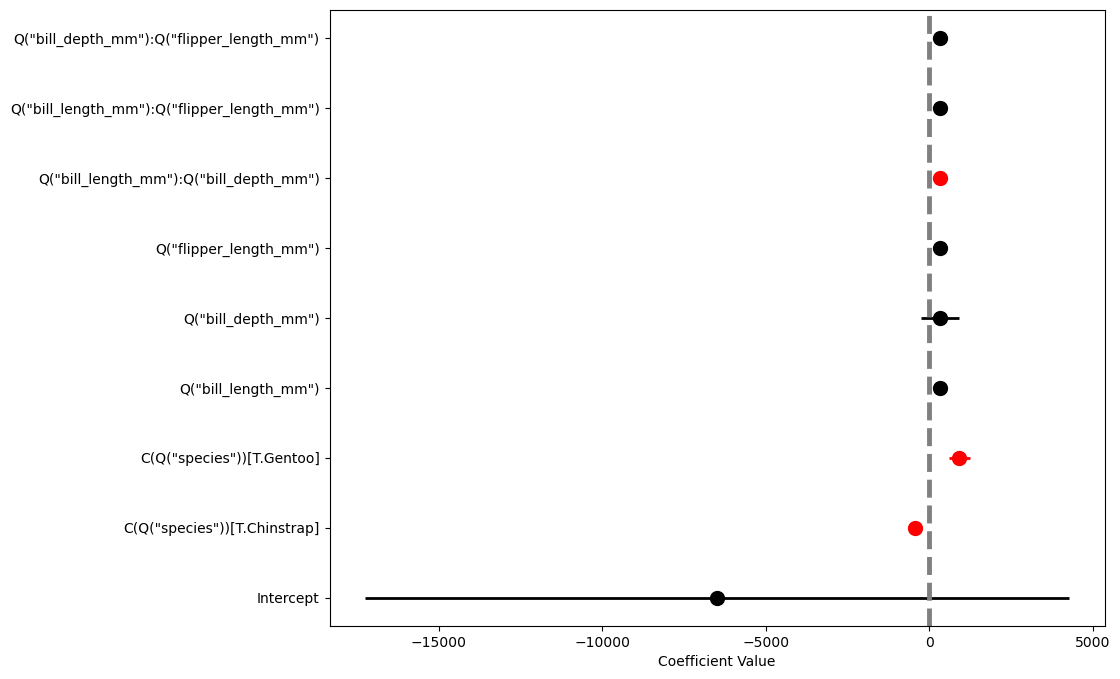

In [105]:
my_coefplot(model_07, zero_nudge=325)

### Model 08: Final Model (Species-Specific Slope for Flipper Length)

In [106]:
model_08 = smf.ols(formula=formula_list[8], 
                   data=df_clean). \
                   fit()

In [107]:
model_08.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     259.2
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          7.91e-121
Time:                        16:36:53   Log-Likelihood:                -2408.3
No. Observations:                 333   AIC:                             4831.
Df Residuals:                     326   BIC:                             4857.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -3259.5585    824.921     -3.951      0.000   -4882.398   -1636.719
C(Q("species"))[T.Chinstrap]                         -100.0775   1401.346     -0.071      0.943   -2856.901    2656.746
C(Q("species"))[T.Gentoo]                           -2233.5848   1337.167     -1.670      0.096   -4864.150     396.980
Q("flipper_length_mm")                                 24.8689      4.421      5.625      0.000      16.172      33.566
Q("flipper_length_mm"):C(Q("species"))[T.Chinstrap]    -3.0247      7.248     -0.417      0.677     -17.282      11.233
Q("flipper_length_mm"):C(Q("species"))[T.Gentoo]       11.2368      6.528      1.721      0.086      -1.605      24.079
Q("bill_length_mm")                                    57.6468      7.327      7.867      0.000      43.232      72.061
==============================================================================
Omnibus:                        6.111   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.069
Skew:                           0.330   Prob(JB):                       0.0481
Kurtosis:                       3.029   Cond. No.                     2.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

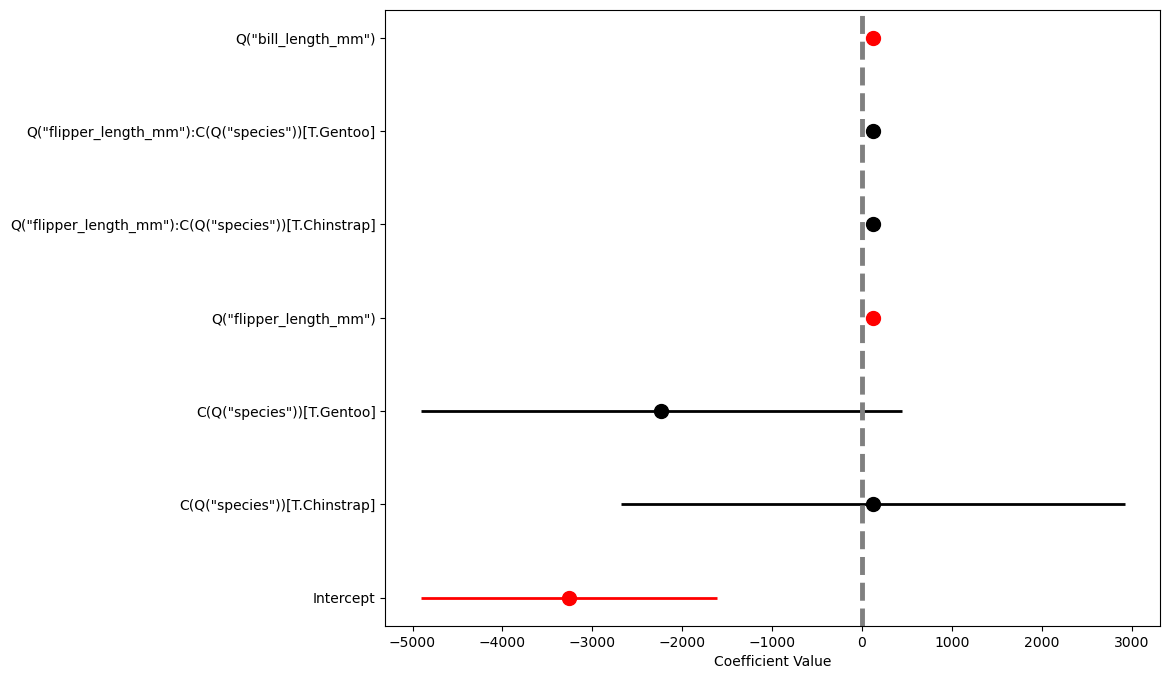

In [108]:
my_coefplot(model_08)

### Compare Fitted Models - Training Data

In [109]:
ols_results_list = []

for model in range(len(formula_list)):
    ols_results_list.append(fit_and_assess_ols(model, 
                                               formula_list[model], 
                                               df))

In [110]:
ols_results_df = pd.concat(ols_results_list, 
                           ignore_index=True)

### **THE TRAINING SET RESULTS ARE DISPLAYED BELOW. THE TRAINING SET R-SQUARED FOR THE MOST PART INCREASES AS THE NUMBER OF REGRESSION COEFFICIENTS INCREASES! THE TRAINING SET RMSE FOR THE MOST PART DECREASES AS THE NUMBER OF REGRESSION COEFFICIENTS INCREASES!**

### **THE TRAINING SET DOES NOT KNOW THE GENERAL RELATIONSHIPS BETWEEN THE OUTPUT AND INPUTS. MODELS WITH MANY FEATURES CAN OVERFIT THE TRAINING BECAUSE THEY ARE ABLE TO MEMORIZE THE BEHAVIOR CONTAINED IN THE TRAINING SET!**

### **THE TRAINING SET PERFORMANCE METRICS DO NOT SELECT THAT MODEL AS THE BEST!**

### **STATISTICALLY SIGNIFICANT FEATURES DO NOT NECESSARILY MEAN A MODEL IS CORRECT!**

#### We see model 3 w/ 6 coefs has a 0.847 R-squared and model 7 w/ 9 coefs has a 0.850 R-squared.

In [111]:
ols_results_df

,model_name,model_formula,num_coefs,R-squared,RMSE
0,0,"Q(""body_mass_g"") ~ 1",1,0.000000,800.781229
1,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3,0.669672,460.242382
2,2,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",4,0.761470,391.097417
3,3,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",6,0.847125,313.099358
4,4,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",10,0.813006,346.280496
5,5,"Q(""body_mass_g"") ~ C(Q(""species"")) * (Q(""bill_...",12,0.853791,306.197389
6,6,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",6,0.789967,366.993220
7,7,"Q(""body_mass_g"") ~ (Q(""bill_length_mm"") + Q(""b...",9,0.850050,310.089872
8,8,"Q(""body_mass_g"") ~ Q(""flipper_length_mm"") + Q(...",7,0.824606,335.367918


In [112]:
model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     369.1
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          4.22e-132
Time:                        16:36:53   Log-Likelihood:                -2384.8
No. Observations:                 333   AIC:                             4782.
Df Residuals:                     327   BIC:                             4805.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4282.0802    497.832     -8.601      0.000   -5261.438   -3302.723
C(Q("species"))[T.Chinstrap]  -496.7583     82.469     -6.024      0.000    -658.995    -334.521
C(Q("species"))[T.Gentoo]      965.1983    141.770      6.808      0.000     686.301    1244.096
Q("bill_length_mm")             39.7184      7.227      5.496      0.000      25.501      53.936
Q("bill_depth_mm")             141.7714     19.163      7.398      0.000     104.072     179.470
Q("flipper_length_mm")          20.2264      3.135      6.452      0.000      14.059      26.394
==============================================================================
Omnibus:                        7.321   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.159
Skew:                           0.348   Prob(JB):                       0.0279
Kurtosis:                       3.179   Cond. No.                     6.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

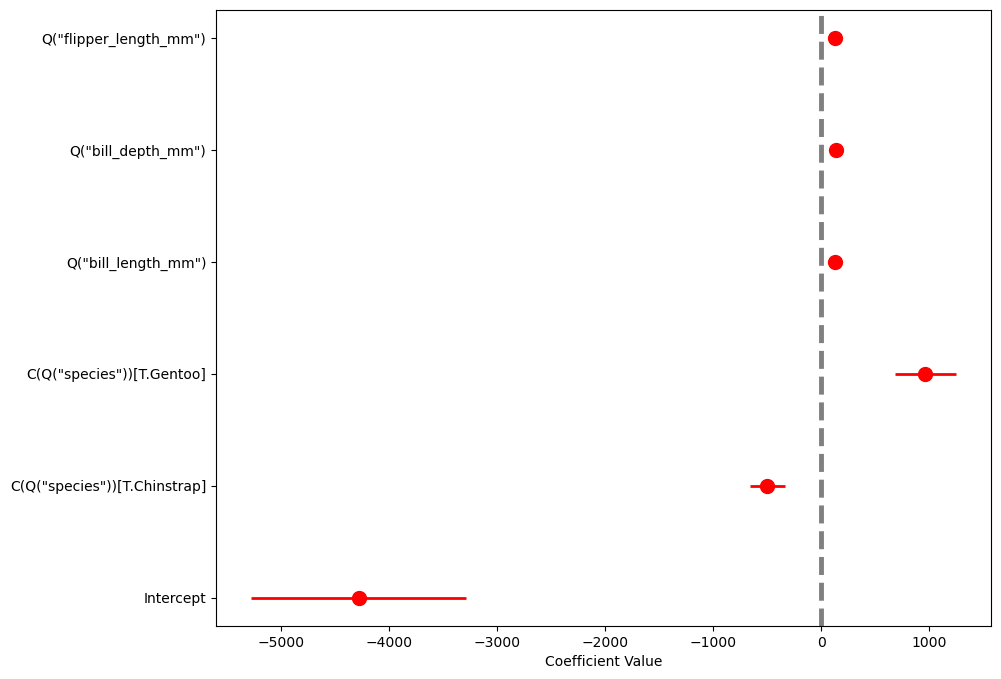

In [113]:
my_coefplot(model_03)

In [114]:
model_07.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("body_mass_g")   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     233.7
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.30e-129
Time:                        16:36:53   Log-Likelihood:                -2381.7
No. Observations:                 333   AIC:                             4781.
Df Residuals:                     324   BIC:                             4816.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                  -6490.4539   5383.685     -1.206      0.229   -1.71e+04    4100.938
C(Q("species"))[T.Chinstrap]                -441.1314     89.228     -4.944      0.000    -616.671    -265.592
C(Q("species"))[T.Gentoo]                    908.7480    162.852      5.580      0.000     588.366    1229.130
Q("bill_length_mm")                          139.4687     83.530      1.670      0.096     -24.860     303.798
Q("bill_depth_mm")                           297.0222    288.078      1.031      0.303    -269.718     863.762
Q("flipper_length_mm")                         7.1624     28.747      0.249      0.803     -49.391      63.716
Q("bill_length_mm"):Q("bill_depth_mm")        -6.4401      2.765     -2.329      0.020     -11.880      -1.000
Q("bill_length_mm"):Q("flipper_length_mm")     0.0691      0.294      0.235      0.815      -0.510       0.648
Q("bill_depth_mm"):Q("flipper_length_mm")      0.5889      1.598      0.369      0.713      -2.554       3.732
==============================================================================
Omnibus:                        6.344   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.131
Skew:                           0.321   Prob(JB):                       0.0466
Kurtosis:                       3.173   Cond. No.                     3.04e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

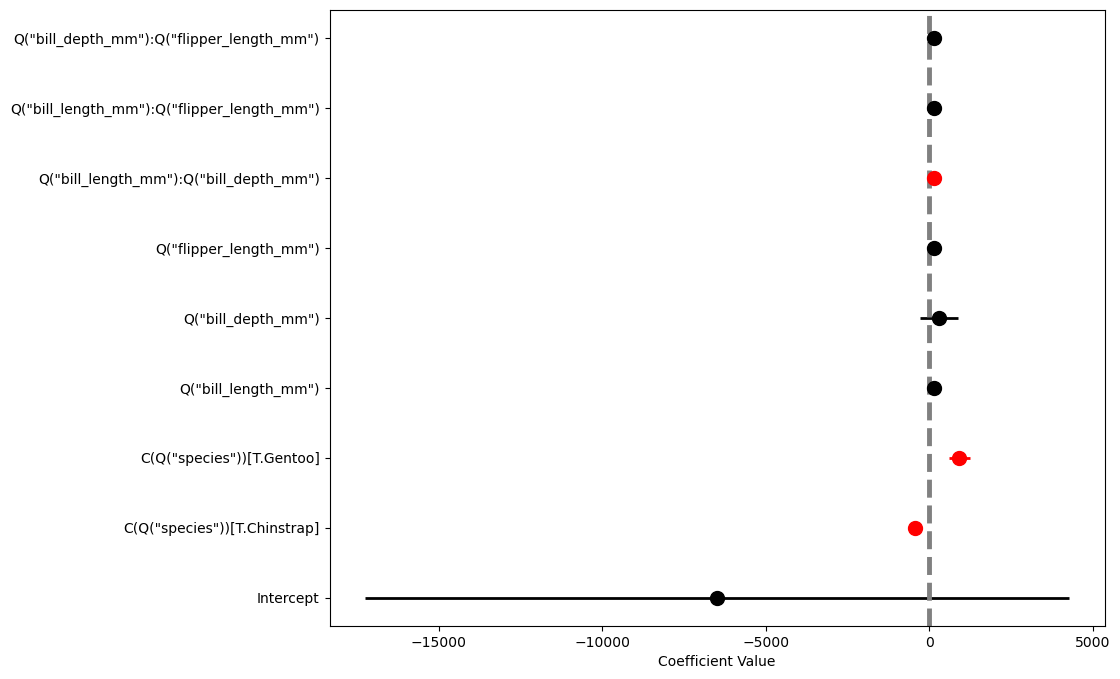

In [115]:
my_coefplot(model_07)

## Fit Linear Regression Models w/ Cross-Validation - Test Data

### Functions

In [116]:
def linear_regression_cross_val_score(model, formula, init_model, df, cv):
    """
    Perform cross-validated evaluation of a linear-style model using a Patsy formula.

    This function builds design matrices from `formula` and `df` using patsy.dmatrices,
    then runs cross-validation using sklearn.model_selection.cross_val_score to compute per-fold
    R-squared and root-mean-squared-error (RMSE) scores. The per-fold results and some metadata
    are returned as a pandas DataFrame.

    Parameters
    ----------
    model : str
        A human-readable name for the model; stored in the returned DataFrame.
    formula : str
        A Patsy-compatible formula string (e.g. "y ~ x1 + x2 + C(group)") used to create y and X.
    init_model : object
        An unfitted scikit-learn-style estimator (must implement fit/predict and be compatible with
        sklearn.model_selection.cross_val_score). Example: LinearRegression().
    df : pandas.DataFrame
        DataFrame containing all variables referenced in `formula`.
    cv : int or cross-validation splitter
        Number of folds (int) or a cross-validation splitter instance passed to cross_val_score.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with one row per CV fold containing:
        - 'R-squared' : R^2 score on the test fold (from cross_val_score default scoring)
        - 'RMSE' : Root mean squared error on the test fold
        - 'fold_id' : 1-based fold identifier
        - 'model_name' : the provided `model`
        - 'model_formula' : the provided `formula`
        - 'num_coefs' : number of columns in the design matrix X
    """
    # Create the feature and output arrays using the formula
    y, X = dmatrices( formula, data=df )
    
    # Train and test within each fold - return the test set scores
    # R-squared
    test_r2 = cross_val_score(init_model, 
                              X, 
                              y.ravel(),
                              cv=cv)
    # RMSE
    test_rmse = -cross_val_score(init_model, 
                                 X, 
                                 y.ravel(), 
                                 cv=cv, 
                                 scoring='neg_root_mean_squared_error')
    
    # Extract model metrics
    results_df=pd.DataFrame({'R-squared': test_r2,
                             'RMSE': test_rmse})
    results_df['fold_id'] = results_df.index + 1
    results_df['model_name'] = model
    results_df['model_formula'] = formula
    results_df['num_coefs'] = X.shape[1]

    # Return the results DataFrame
    return results_df

### Fit w/ Cross-Validation

In [117]:
kf = KFold(n_splits=5, shuffle=True, random_state=101)

In [118]:
lm = LinearRegression(fit_intercept=False)

### Compare Fitted Models - Test Data

In [119]:
cv_score_list = []

for model in range(len(formula_list)):
    print('-- Formula ID %d --' % model)
    
    cv_score_list.append(linear_regression_cross_val_score(model, 
                                                           formula_list[model], 
                                                           init_model=lm, 
                                                           df=df_clean, 
                                                           cv=kf) )

-- Formula ID 0 --
-- Formula ID 1 --
-- Formula ID 2 --
-- Formula ID 3 --
-- Formula ID 4 --
-- Formula ID 5 --
-- Formula ID 6 --
-- Formula ID 7 --
-- Formula ID 8 --


In [120]:
cv_score_df=pd.concat(cv_score_list, ignore_index=True)

In [121]:
cv_score_df

,R-squared,RMSE,fold_id,model_name,model_formula,num_coefs
0,-4.526133e-02,812.420097,1,0,"Q(""body_mass_g"") ~ 1",1
1,-3.363930e-07,735.247849,2,0,"Q(""body_mass_g"") ~ 1",1
2,-6.889831e-05,792.792792,3,0,"Q(""body_mass_g"") ~ 1",1
3,-6.097962e-03,839.647092,4,0,"Q(""body_mass_g"") ~ 1",1
4,-1.400301e-02,845.708003,5,0,"Q(""body_mass_g"") ~ 1",1
5,6.381451e-01,478.008282,1,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3
6,6.301439e-01,447.146775,2,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3
7,7.303516e-01,411.664747,3,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3
8,6.918962e-01,464.649173,4,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3
9,6.414559e-01,502.888977,5,1,"Q(""body_mass_g"") ~ C(Q(""species""))",3


### Visualize Average R-squared w/ 1 Standard Error Interval 68% Confidence Interval on the Average

In [122]:
cv_score_df.groupby(['model_name', 
                     'num_coefs', 
                     'model_formula']). \
            aggregate(r2_avg=('R-squared', 'mean'),
                      r2_sem=('R-squared', 'sem')). \
                      reset_index(). \
                      sort_values(by='r2_avg', ascending=False). \
                      reset_index(drop=True)

,model_name,num_coefs,model_formula,r2_avg,r2_sem
0,5,12,"Q(""body_mass_g"") ~ C(Q(""species"")) * (Q(""bill_...",0.843028,0.014216
1,7,9,"Q(""body_mass_g"") ~ (Q(""bill_length_mm"") + Q(""b...",0.840915,0.016152
2,3,6,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",0.840654,0.017145
3,8,7,"Q(""body_mass_g"") ~ Q(""flipper_length_mm"") + Q(...",0.816723,0.012749
4,4,10,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",0.782833,0.009847
5,6,6,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",0.780882,0.022054
6,2,4,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",0.751056,0.019701
7,1,3,"Q(""body_mass_g"") ~ C(Q(""species""))",0.666399,0.019333
8,0,1,"Q(""body_mass_g"") ~ 1",-0.013086,0.008443


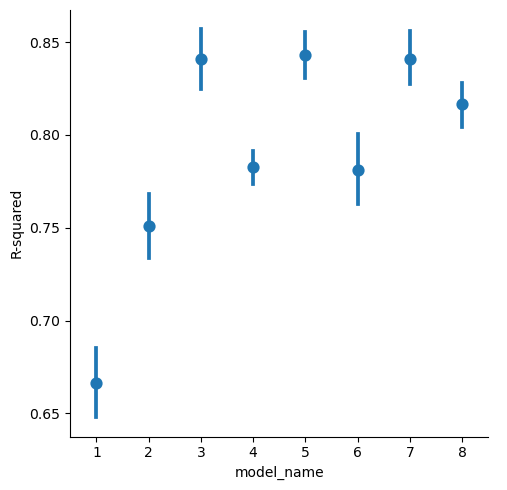

In [123]:
sns.catplot(data=cv_score_df.loc[cv_score_df.model_name > 0, :], 
            x='model_name', 
            y='R-squared', 
            kind='point', 
            linestyle='none',
            errorbar=('ci', 68))
plt.show()

### Visualize Average RMSE w/ 1 Standard Error Interval 68% Confidence Interval on the Average

In [124]:
cv_score_df.groupby(['model_name', 
                     'num_coefs', 
                     'model_formula']). \
            aggregate(rmse_avg=('RMSE', 'mean'),
                      rmse_sem=('RMSE', 'sem')). \
                      reset_index(). \
                      sort_values(by='rmse_avg', ascending=True). \
                      reset_index(drop=True)

,model_name,num_coefs,model_formula,rmse_avg,rmse_sem
0,5,12,"Q(""body_mass_g"") ~ C(Q(""species"")) * (Q(""bill_...",314.559630,10.234882
1,3,6,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",316.115532,12.343121
2,7,9,"Q(""body_mass_g"") ~ (Q(""bill_length_mm"") + Q(""b...",316.191290,12.867974
3,8,7,"Q(""body_mass_g"") ~ Q(""flipper_length_mm"") + Q(...",340.784937,7.899129
4,6,6,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",371.115229,14.909940
5,4,10,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",372.733356,14.741446
6,2,4,"Q(""body_mass_g"") ~ Q(""bill_length_mm"") + Q(""bi...",396.580187,10.569666
7,1,3,"Q(""body_mass_g"") ~ C(Q(""species""))",460.871591,15.302093
8,0,1,"Q(""body_mass_g"") ~ 1",805.163167,19.908372


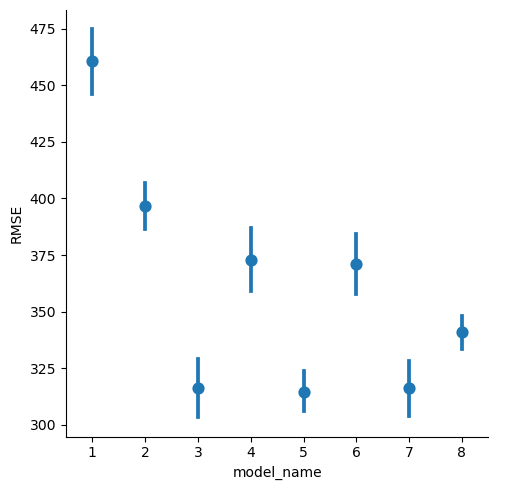

In [125]:
sns.catplot(data=cv_score_df.loc[cv_score_df.model_name > 0, :], 
            x='model_name', 
            y='RMSE', 
            kind='point', 
            linestyle='none',
            errorbar=('ci', 68))
plt.show()

## Save Best Model - Model 3 w/ Highest R-squared and Lowest RMSE w/ Least Coefficients

### Save Model

In [126]:
with open('model_03.pkl', 'wb') as f:
    pickle.dump(model_03, f)
print('model saved to model_03.pkl')

model saved to model_03.pkl


### Load Model

In [127]:
try:
    with open('model_03.pkl', 'rb') as f:
        model_03 = pickle.load(f)
except FileNotFoundError:
    print('model_03.pkl not found')
except pickle.UnpicklingError:
    print('failed to unpickle model_03.pkl (file may be corrupted or unsafe)')
else:
    print('model loaded from model_03.pkl')

model loaded from model_03.pkl


### Inference on New Data

In [128]:
new_penguin_data = pd.DataFrame({
    'bill_length_mm': [22.0],
    'bill_depth_mm': [15.0],
    'flipper_length_mm': [200.0],
    'species': ['Gentoo']
})

predicted_body_mass = model_03.predict(new_penguin_data)
print(f'predicted body mass for the new penguin: {predicted_body_mass[0]:.2f} grams')

predicted body mass for the new penguin: 3728.78 grams
